<a href="https://colab.research.google.com/drive/1FLlrv4fzFqGv4mpMGHt22x37ljxj2xTR?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Научно-исследовательская работа</h1>

<h2 align="center"><b>"Численное моделирование механических систем"</b></h2>

<i>Выполнили:
* Липская Мария
* Карасева Ольга
* Жижченко Александр
* Пругло Иван  

Научный руководитель:
* Федоров Владимир Сергеевич

*Цели работы*:
* научиться численно моделировать механические системы
* изучить решения ограниченной задачи трёх тел
* разобраться с положением равновесия в точках Лагранжа

<h1 align="center"><b>Введение</b></h1>

_________________
  
<h2 align="center"><i><b>Основные используемые понятия</b></i></h2>

1. *Точки Лагранжа* - точки в системе из двух массивных тел, в которых третье тело с пренебрежимо малой массой, не испытывающее воздействия никаких других сил, кроме гравитационных со стороны двух первых тел, может оставаться неподвижным относительно этих тел.

1. *Полость Роша* - область вокруг объекта в двойной системе, границей которой служит эквипотенциальная поверхность, содержащая первую точку Лагранжа $L_1$

1. *Сфера Хилла* - пространство вокруг объекта, на котором он может удерживать спутники
1. *Гамильтониан* - основная функция, используемая в механике и динамике Гамильтона  
*Вид гамильтониана, используемый в работе:*

$$
  H(x, y, p_x, p_y) = \frac{(p_x + y)^2 + (p_y - x)^2}{2} - U(x, y)
$$


5. *Лагранжиан* - функция описание динамической системы через обобщённые координаты (координаты $(x, y)$ и скорости $(\dot x, \dot y)$). Общий вид:
$L(x, y, \dot x, \dot y) = T - U(x, y)$.

*(Остальные необходимые определения указаны в нужных ячейках)*

Для начала необходимо скачать компилятор Julia



In [1]:
# @title Запуск Julia
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


Подключение необходимых библиотек

In [106]:
using REPL.REPLCompletions: latex_symbols, emoji_symbols
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("Images")
import Pkg; Pkg.add("ProgressBars")
using Images
using Plots
# using PyPlot
using ProgressBars

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [165]:
mu = 0.2
function u(x, y)
    r1 = sqrt((x + mu)^2 + y^2)
    r2 = sqrt((x - 1 + mu)^2 + y^2)
    return (x^2 + y^2) / 2 + (1 - mu) / r1 + mu / r2 + ((1 - mu) * mu) / 2
end

function h(x, y, px, py)
    """Гамильтониан системы"""
    return ((px + y)^2 + (py - x)^2) / 2 - u(x, y)
end


function diff_u_x(x, y)
    """Производная в точке от U(x, y) по x"""
    delta = 1e-5
    return  - (u(x + delta / 2, y) - u(x - delta / 2, y)) / delta
end

function diff_u_y(x, y)
    """Производная в точке от U(x, y) по y"""
    delta = 1e-5
    return  - (u(x, y + delta / 2) - u(x, y - delta / 2)) / delta
end

function x_dot(x, y, px, py)
    """Скорость по x"""
    return px + y
end

function y_dot(x, y, px, py)
    """Скорость по y"""
    return py - x
end

function px_dot(x, y, px, py)
    """Производная по px"""
    return py - x + diff_u_x(x, y)
end

function py_dot(x, y, px, py)
    """Производная по py"""
    return -px - y + diff_u_y(x, y)
end

function x_ddot(x, y, px, py)
    """Вторая производная по x """
    return px_dot(x, y, px, py) + y_dot(x, y, px, py)
end

function y_ddot(x, y, px, py)
    """Вторая производная по Y """
    return py_dot(x, y, px, py) - x_dot(x, y, px, py)
end

function all_dots(x, y, px, py, with_second=true)
    """Все производные: """
    if with_second
        return (x_dot(x, y, px, py), y_dot(x, y, px, py), px_dot(x, y, px, py), py_dot(x, y, px, py), x_ddot(x, y, px, py), y_ddot(x, y, px, py))
    else
        return (x_dot(x, y, px, py), y_dot(x, y, px, py), px_dot(x, y, px, py), py_dot(x, y, px, py))
    end
end

function velocities_half_delta(x, y, px, py, delta_t)
    x_new = x - x_dot(x, y, px, py) * delta_t / 2
    y_new = y - y_dot(x, y, px, py) * delta_t / 2
    px_new = px - px_dot(x, y, px, py) * delta_t / 2
    py_new = py - py_dot(x, y, px, py) * delta_t / 2
    return (x_dot(x_new, y_new, px_new, py_new), y_dot(x_new, y_new, px_new, py_new))
end

function W(x::Float64, y::Float64)
    """Функция нормализации значения"""
    return -log((abs(diff_u_x(x, y)) + abs(diff_u_y(x, y))), ℯ)
end

function h_const(x, y, px=0, py=0)
    """Подсчёт постоянной Якоби"""
    return 0.5 * (x_dot(x, y, px, py) ^ 2 + y_dot(x, y, px, py) ^ 2) - u(x, y)
end


h_const (generic function with 3 methods)

<h1 align="center"> Эпизод I<br> <b>Визуализация точек Лагранжа, полости Роша и сферы Хилла</b></h1>

_________________
Для наглядного представления точек Лагранжа нами была выбрана функция `imshow` из пакета `matplotlib.pyplot`. Она задаёт изображение, как двумерный массив пикселей (в нашем коде массив `DAT`). Его заполнение осуществлялось с помощью перебора значений `i` от 0 до `(lim_x_max - lim_x_min) / step_x` и `j` от 0 до `(lim_y_max - lim_y_min) / step_y`. Каждому пикселю `DAT[i][j]` присваивалось значение `W(i, j)`. Для большей наглядности результата изображение было выведено в чёрно-белом формате `cmap='gray'`


In [166]:
lim_x_min, lim_x_max = -2, 2
step_x = 0.01
lim_y_min, lim_y_max = -2, 2
step_y = 0.01
DAT = zeros(length(lim_x_min:step_x:lim_x_max), length(lim_y_min:step_y:lim_y_max))

for (j, y) in enumerate(lim_x_min:step_x:lim_x_max)
    for (i, x) in enumerate(lim_y_min:step_y:lim_y_max)
        DAT[j, i] = W(x, y)
    end
end



<h1 align="center"> Эпизод II<br> <b>Нахождение координат точек Лагранжа</b></h1>

_______________
Для нахождения координат точек Лагранжа, нами использовались массивы,
```
mx = np.arange(lim_x_min, lim_x_max, step_x)
my = np.arange(lim_y_min, lim_y_max, step_y)
```
которые задаются минимальными значениями, максимальными значениями и шагом изменения с помощью функции `numpy.arrange`. В итоговый массивы точек Лагранжа `ans_x` и `ans_y` заносились координаты, в которых $ \frac{∂}{\partial x}U(x, y) = 0$ и $ \frac{∂}{\partial y}U(x, y) = 0$ (реализовано с помощью приращений и теоремы Лагранжа)
Из массива итоговых точек были исключены координаты центра масс и тел, и получившиеся координаты были добавлены в массивы `L_x` и `L_y` и отсортированы по номеру точки.  
Координаты этих точек также задаются формулами:

\begin{gather}
L_1 \:(R(1 - \sqrt[3]{\frac{\mu}{3}},\; 0))\\
L_2 \:(R(1 + \sqrt[3]{\frac{\mu}{3}}, \; 0)\\
L_3 \:(R(1 - \frac{5}{12}\mu, \; 0)\\
L_4 \:(\frac{R}{2} \cdot \frac{m_1-m_2}{m_1+m_2}, \; \frac{\sqrt[3]{3}}{2}R)\\
L_5 \:(\frac{R}{2} \cdot \frac{m_1-m_2}{m_1+m_2}, \; -\frac{\sqrt[3]{3}}{2}R)\\
\end{gather}

где:  

* $m_1$ - масса большего тела  
* $m_2$ - масса меньшего тела   
* $R$ - расстояние между телами


In [170]:
ans_x = []
ans_y = []
epsilon = 0

for x in lim_x_min:step_x:lim_x_max
    for y in lim_y_min:step_y:lim_y_max
         if (u(x, y) - u(x - step_x, y)) * (u(x + step_x, y) - u(x, y)) < epsilon && (u(x, y) - u(x, y - step_y)) * (u(x, y + step_y) - u(x, y)) < epsilon
                append!(ans_x, x)
                append!(ans_y, y)
        end
    end
end
L_x = [ans_x[7], ans_x[9], ans_x[1], ans_x[4], ans_x[3]]
L_y = [ans_y[7], ans_y[9], ans_y[1], ans_y[4], ans_y[3]]
println(L_x)
println(L_y)

[0.44, 1.27, -1.08, 0.3, 0.3]
[0.0, 0.0, 0.0, 0.87, -0.87]


<h1 align="center"> Эпизод III<br> <b>Моделирование движения вблизи точек Лагранжа</b></h1>

__________

Движение точки в задаче трёх тел описывается уравнениями движения, описанными во введении. В программе перемещение точки задаётся функцией `move(x, y, px=0, py=0, t=100000, scfale_large)`, где `x` и `y` - обязательные параметры, являющиеся начальными координатами, а `px` и `py` начальные импульсы тела, `t` - общее время движения тела, `scale_large` (если `True`, то показано движение тела относительно системы тел, если `False`, то демонстрируется движение у точки Лагранжа)

In [184]:
function move_leapfrog(x::Float64, y::Float64; px::Float64=0.0, py::Float64=0.0, t::Int64=100000)
    delta_t = 1e-4
    x_vel, y_vel = velocities_half_delta(x, y, px, py, delta_t)
    x_arr = [x]
    y_arr = [y]
    for i in 0:1:t
        derivatives = all_dots(x_arr[length(x_arr)], y_arr[length(y_arr)], px, py)

        x_vel += derivatives[5] * delta_t
        y_vel += derivatives[6] * delta_t

        push!(x_arr, x_arr[length(x_arr)] + x_vel * delta_t)
        push!(y_arr, y_arr[length(y_arr)] + y_vel * delta_t)

        px += derivatives[3] * delta_t
        py += derivatives[4] * delta_t
    end
    return (x_arr, y_arr)
end


move_leapfrog (generic function with 8 methods)

<h1 align="center"> Эпизод IV<br> <b>Подбор параметров движения в точках Лагранжа</b></h1>

_________

После нахождения координат точек Лагранжа необходимо задать параметры движения по орбите, чтобы тело двигалось вокруг точки Лагранжа по эллипсу: начальный импульс ($p_x$, $p_y$), а также начальное время `t`.  

В точках $L_4$ и $L_5$ наблюдается устойчивое равновесие, из-за чего тело при удалении от этих точек стремится вернуться в их окрестности, поэтому движению в этих точках описывается множеством значений $p_x$ и $p_y$ (нами были взяты значения $\pm 1$ и $0.5$ соответственно).  

В точках $L_1, L_2, L_3$ тело находится в положении неустойчивого равновесия, поэтому количество удовлетворяющих условию начальных импульсов значительно меньше. Вначале было решено подобрать параметры с помощью производных ($\frac{\partial H}{\partial p_x} = 0, \frac{\partial H}{\partial p_y} = 0$), подсчёт которых реализован в виде функции `ext_h(i)` (где `i` - номер точки Лагранжа), но из-за недостаточно точных расчётов параметры были подобраны бинарным поиском (функция `ext_h(i)` при маленьком `delta` работает очень медленно).

Итоговые параметры продемонстрированы в коде ниже (каждая точка Лагранжа строится в отдельной ячейке и к ней написаны характеристики получившегося эллипса). В точках $L_4, L_5$ существует множество устойчивых траекторий, поэтому характеристики орбит в данных точках мы не вычисляли.

<h3>Параметры орбиты вокруг $L_1$:</h3>

$a ≈ 0.002$ - большая полуось

$b \approx 0.0006$ - малая полуось

$e \approx 0.95$ - эксцентриситет

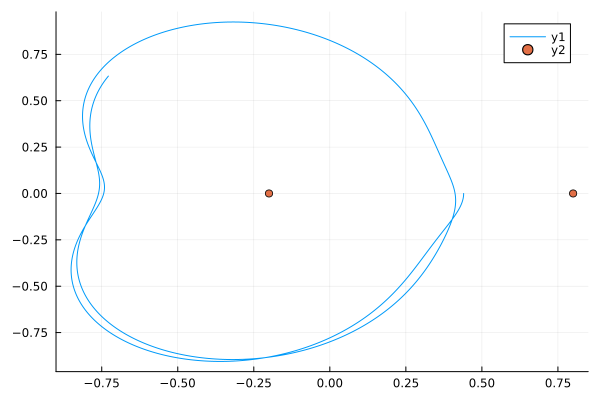

In [193]:
using Plots
L1 = move_leapfrog(L_x[1] - 1e-6, 0.0+1e-10, px=0.0, py=0.0, t=100000)
Plots.plot(L1[1], L1[2])